In [104]:
from importlib.metadata import version

pkgs = ["matplotlib",  # Plotting library
        "numpy",       # PyTorch & TensorFlow dependency
        "tiktoken",    # Tokenizer
        "torch",       # Deep learning library
        "tensorflow",  # For OpenAI's pretrained weights
        "pandas"       # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.3
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.7.1
tensorflow version: 2.19.0
pandas version: 2.3.1


In [105]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 


sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


we have to balance the dataset as currently we have a large number of ham messages

In [106]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["label", "text"])

In [107]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [108]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

imbalanced dataset

In [109]:
def create_balanced_dataset(df):

    # count the instance of spam
    num_spam= df[df["label"] == 'spam'].shape[0]     # 747

    # randomly sample "ham" instances to match the number of "spam" instance
    ham_subsets= df[df["label"]=="ham"].sample(num_spam, random_state=123)

    # concatenate the spam and ham subsets
    balanced_df= pd.concat([ham_subsets, df[df["label"]=="spam"]])

    return balanced_df


balanced_df= create_balanced_dataset(df)
balanced_df['label'].value_counts()

label
ham     747
spam    747
Name: count, dtype: int64

reset_index(drop=): It is a boolean flag,
* True – It does not add the current row index as a new column in DataFrame.
* False (Default) – It adds the current row index as a new column in DataFrame.

In [110]:
balanced_df["label"] = balanced_df["label"].map({"ham": 0, "spam": 1})    

In [111]:
# randomly split the dataset

def random_split(df, train_frac, validation_frac):

    # shuffle the entire dataset
    df= df.sample(frac=1, random_state= 123).reset_index(drop= True)    # do not add the current row index as a new column

    # calculate the split indices
    train_end= int(len(df)* train_frac)
    validation_end= train_end + int(len(df) * validation_frac)

    # split the dataset
    train_df= df[:train_end]
    validation_df= df[train_end:validation_end]
    test_df= df[validation_end:]

    return train_df, validation_df, test_df


train_df, validation_df, test_df= random_split(balanced_df, 0.7, 0.2)

# store them for our later use
train_df.to_csv("train.csv",  index=False)
validation_df.to_csv("validation.csv", index=False)
test_df.to_csv("test.csv", index=False)

In [112]:
train_df

,label,text
0,0,Dude how do you like the buff wind.
1,0,Tessy..pls do me a favor. Pls convey my birthd...
2,1,Reminder: You have not downloaded the content ...
3,1,Got what it takes 2 take part in the WRC Rally...
4,1,"Shop till u Drop, IS IT YOU, either 10K, 5K, £..."
...,...,...
1040,1,4mths half price Orange line rental & latest c...
1041,1,Thanks for the Vote. Now sing along with the s...
1042,1,IMPORTANT INFORMATION 4 ORANGE USER 0796XXXXXX...
1043,1,Urgent! call 09066612661 from landline. Your c...


In [113]:
test_df["label"].value_counts(), train_df['label'].value_counts()

(label
 1    80
 0    71
 Name: count, dtype: int64,
 label
 0    528
 1    517
 Name: count, dtype: int64)

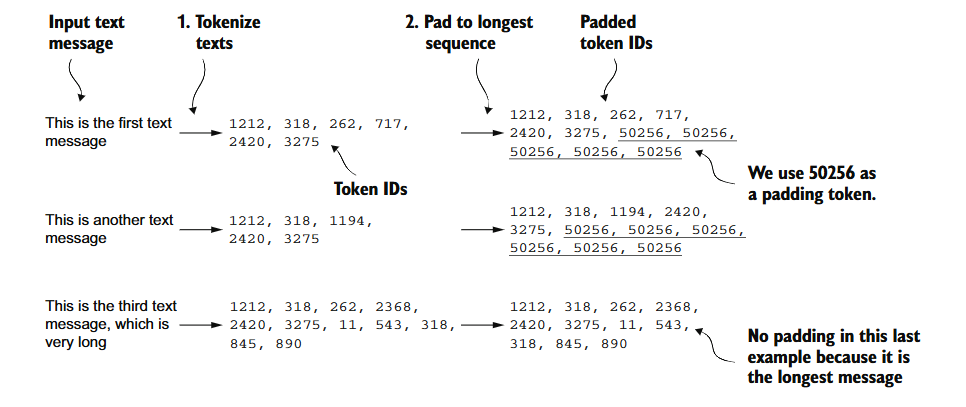

* find the longest sequence in the dataset
* pad the rest of them with the eos padding token

In [114]:
len(train_df)

1045

Lets build the dataset and the dataloader classes

In [115]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class SpamDataset(Dataset):

    def __init__(self, csv_file, tokenizer, max_length= None, pad_token_id= 50256):
        self.data= pd.read_csv(csv_file)

        # encode the text now. Make sure in a list
        self.encoded_texts= [
            tokenizer.encode(text) for text in self.data['text']
        ]

        if max_length is None:
            self.max_length= self._longest_encoded_length()
        else:
            # if let say u got very long docs like newspapers,
            # and you are set to classify into political/finance/sports,etc
            # you might want to set a max_length to like the first 1000/2000 tokens 

            self.max_length= max_length
            # truncate sequences if they are longer than max_length
            self.encoded_texts= [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]

            # pad the sequence to the longest sequence
        self.encoded_texts= [
            encoded_text + [pad_token_id]* (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
        

    # getting the labels and the texts as tensors
    def __getitem__(self, index):
        encoded= self.encoded_texts[index]
        label= self.data.iloc[index]['label']
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length=0
        for encoded_text in self.encoded_texts:
            encoded_length= len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [116]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

train_dataset= SpamDataset(
    csv_file="train.csv",
    tokenizer=tiktoken.get_encoding("gpt2"),
    max_length=None,
)
print(train_dataset.max_length)

[50256]
120


In [117]:
val_dataset= SpamDataset(
    csv_file= 'validation.csv',
    max_length= train_dataset.max_length,
    tokenizer=tiktoken.get_encoding("gpt2")
)

test_dataset= SpamDataset(
    csv_file= 'test.csv',
    max_length= train_dataset.max_length,
    tokenizer=tiktoken.get_encoding("gpt2")
)

In [118]:
from torch.utils.data import DataLoader

num_workers= 0
batch_size= 8

torch.manual_seed(123)  # for reproducibility

train_loader= DataLoader(
    dataset= train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True  # drop the last incomplete batch
)

val_loader= DataLoader(
    dataset= val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False  # keep the last incomplete batch
)

test_loader= DataLoader(
    dataset= test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False  # keep the last incomplete batch
)

In [119]:
len(train_loader)

130

as a verification lets iterate through the dataset once to ensure there are no issue

In [120]:
print('train loader')
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

train loader
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
130 training batches
38 validation batches
19 test batches


initializing the GPT Model from previous chapters

In [121]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [122]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


lets double check this model if it is working

In [123]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text,
)
text_1= "duck-duck and goose is a game"

token_ids= generate_text_simple(
    model= model,
    idx= text_to_token_ids(text_1, tokenizer),
    max_new_tokens= 50,
    context_size= BASE_CONFIG["context_length"],
)
print(token_ids_to_text(token_ids, tokenizer))

duck-duck and goose is a game of chicken.

The game is played in a small, open room with a large, open door. The player must enter the room and then the door will open. The player must then take the stairs to the next room. The player must


Before we finetune the model as a classifier, let's see if the model can perhaps already classify spam messages via prompting

In [124]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids= generate_text_simple(
    model= model,
    idx= text_to_token_ids(text_2, tokenizer),
    max_new_tokens= 23, 
    context_size= BASE_CONFIG["context_length"],
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


* As we can see, the model is not very good at following instructions
* This is expected, since it has only been pretrained and not instruction-finetuned (instruction finetuning will be covered in the next chapter)

## Adding a classification HEAD

In [125]:
print (model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

* The above is our architecture model as we implemented in chapter 4
* We will be fine-tuning only the output layer. The last layer.
* We will be freezing all the layers of the model, we first make all the layers non- trainable 

In [126]:
for param in model.parameters():
    param.requires_grad= False

```
(11): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
  )
  (final_norm): LayerNorm()
  (out_head): Linear(in_features=768, out_features=50257, bias=False)
)
```

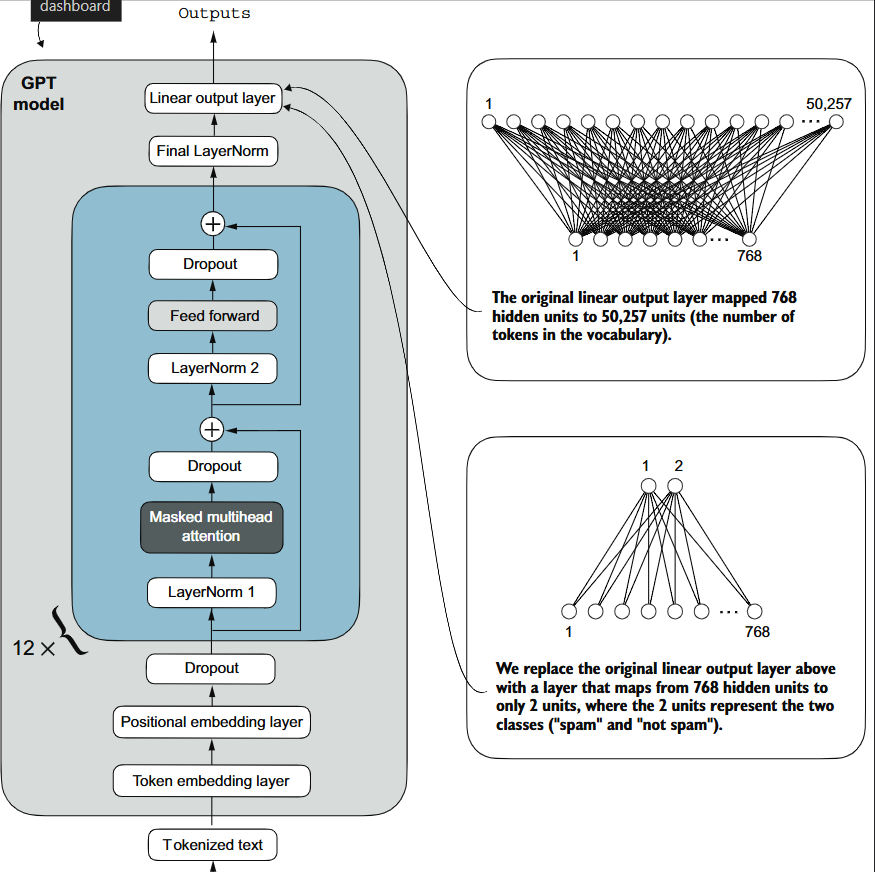 

* replace the output_layer (model.out_head), which maps the layer inputs to 50257 dimensions
* as we want the output to be classified into only 2 classes-> [spam, not spam]
* we can replace the output layer as shown below, which will be trainable by default
* if you classify into more than 2 classes then you make as many number of categories

In [127]:
torch.manual_seed(123)

num_classes= 2
model.out_head= torch.nn.Linear(in_features=BASE_CONFIG['emb_dim'], out_features= num_classes)

* we are also making the last transformer block and the final LayerNorm module connected to the last transformer block which als connects the out_head, trainable

In [128]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad= True
for param in model.final_norm.parameters():
    param.requires_grad= True

lets check what we just did

In [129]:
inputs= tokenizer.encode("Do you have time")
inputs= torch.tensor(inputs).unsqueeze(0)   # Add batch dimension
print("Inputs", inputs)
inputs.shape

Inputs tensor([[5211,  345,  423,  640]])


torch.Size([1, 4])

now you will see  that it only outputs in 2 dimensions

In [130]:
with torch.no_grad():
    outputs= model(inputs)

print("Outputs shape:", outputs.shape)
print(outputs)
# tokenizer.decode(outputs[0].argmax(dim=-1).tolist())    

Outputs shape: torch.Size([1, 4, 2])
tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])


for each input token there are 2 output tokens

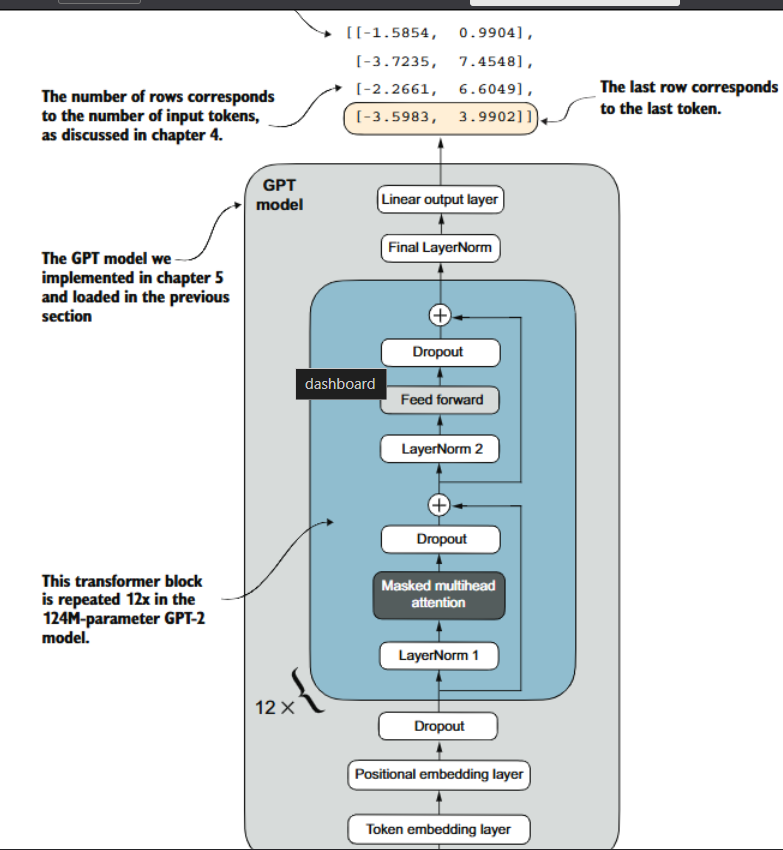

* due to the causal attention mechanism, the last token contains most information about all the rest of the tokens
* so we finetune only the last token for classification task

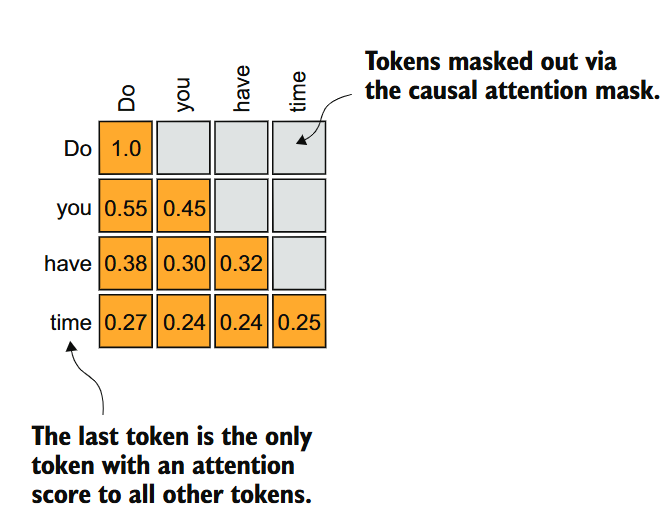

the last token computes attention scores of all the preceding tokens

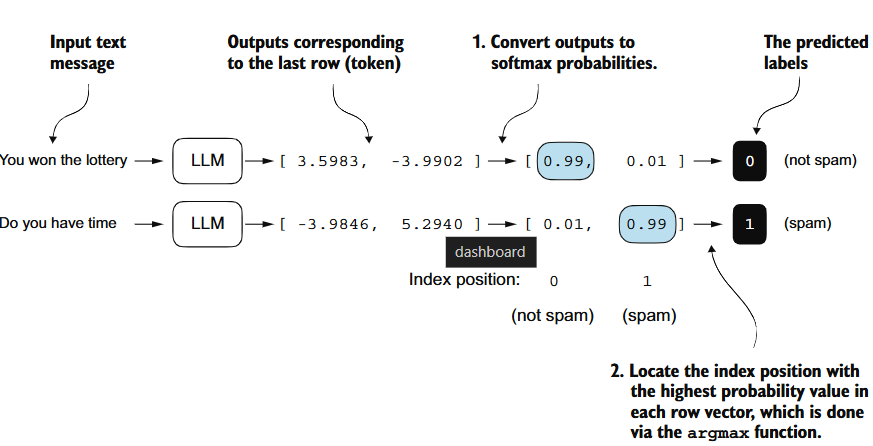

In [131]:
outputs.shape

torch.Size([1, 4, 2])

In [132]:
print("Last output token: ",outputs[:, -1, :])

Last output token:  tensor([[-3.5983,  3.9902]])


## Calculating the classification loss and the accuracy

* convert the outputs to probability scores using the softmax function 
* then obtain the index position of the largest prob value via the argmax function

In [133]:
probas= torch.softmax(outputs[:, -1,:], dim=-1)
label= torch.argmax(probas)
print("Predicted label:", label.item())

Predicted label: 1


* the largest outputs corresponds to the largest probability

In [134]:
logits= outputs[:, -1, :]
label= torch.argmax(logits, dim=-1)
print("Class label:", label.item())

Class label: 1


#### To calculate the classification accuracy, we can apply the preceding argmax-based prediction code to all examples in a dataset and calculate the fraction of correct predictions as follows:

In [135]:
probas

tensor([[5.0598e-04, 9.9949e-01]])

In [136]:
torch.argmax(probas)

tensor(1)

In [137]:
target= torch.tensor([1,0,1,0,1])
pred= torch.tensor([1,0,1,1,1])  # Example predictions

target.shape, 
(target== pred).sum().item(), 
(target== pred).sum().item()/ target.shape[0]


0.8

In [138]:
def calc_accuracy_loader(data_loader, model, device, num_batches= None):
    
    # put the model in eval mode
    model.eval()
    correct_predictions, num_examples=0,0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches= min(len(data_loader), num_batches)
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i< num_batches:
            input_batch, target_batch= input_batch.to(device), target_batch.to(device)
            
            with torch.no_grad():
                logits= model(input_batch) [:, -1, :]       # get the last token output scores
            predicted_labels= torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]       # since we are processing in batches
            correct_predictions += (predicted_labels == target_batch).sum().item()

        else:
            break
    
    return correct_predictions / num_examples if num_examples > 0 else 0.0

apply this functions


In [139]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
torch.manual_seed(123)

# remember the model is still untrained
train_accuracy= calc_accuracy_loader(train_loader, model, device, num_batches=10)
print(f"Train accuracy: {train_accuracy*100:.2%}")
val_accuracy= calc_accuracy_loader(val_loader, model, device, num_batches=10)
print(f"Validation accuracy: {val_accuracy*100:.2%}")
test_accuracy= calc_accuracy_loader(test_loader, model, device, num_batches=10)
print(f"Test accuracy: {test_accuracy*100:.2%}")

Train accuracy: 4625.00%
Validation accuracy: 4500.00%
Test accuracy: 5375.00%


* the prediction accuracies are not very good, since we haven't finetuned the model, yet
* Before we can start finetuning (/training), we first have to define the loss function we want to optimize during training

* The goal is to maximize the spam classification accuracy of the model; however, classification accuracy is not a differentiable function

* Hence, instead, we minimize the cross-entropy loss as a proxy for maximizing the classification accuracy (you can learn more about this topic in lecture 8 of my freely available Introduction to Deep Learning class)

* The calc_loss_batch function is the same here as in chapter 5, except that we are only interested in optimizing the last token model(input_batch)[:, -1, :] instead of all tokens model(input_batch)

calc_loss is same as chapter 5

In [140]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch= input_batch.to(device), target_batch.to(device)
    logits= model(input_batch) [:, -1, :]       # changed this
    loss= torch.nn.functional.cross_entropy(logits, target_batch)  # changed this
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss= 0
    if len(data_loader)==0:
        print("Length of data_loader is 0. Returning NaN")
        return float("nan")
    elif num_batches is None:
        num_batches= len(data_loader)
    
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches= min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i< num_batches:
            loss= calc_loss_batch(input_batch, target_batch, model, device)
            total_loss+= loss.item()
        else:
            break
    return total_loss / num_batches          

In [141]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.179


Now lets FineTune The model

* This train_classifier_simple is identical to the train_simple
* Except:
    * The only two differences are that we now track the number of training examples seen (examples_seen) instead of the number of tokens seen
    * calculate the accuracy after each epoch instead of printing a sample text after each epoch

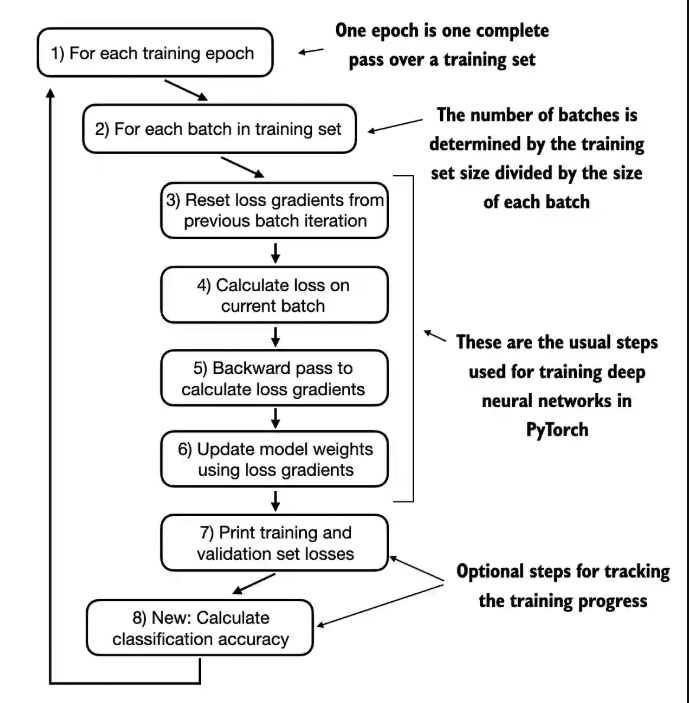

In [142]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):

    train_losses, val_losses, train_accs, val_accs= [], [], [], []
    examples_seen, global_step= 0, -1

    # main training loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()   # reset loss gradients from prev batch
            loss= calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()        # update the model weights using loss gradients
            examples_seen += input_batch.shape[0]        # track examples instead of tokens
            global_step += 1

            # optional evaluation step
            if global_step % eval_freq ==0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        train_accuracy= calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy= calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")

        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)


    return train_losses, val_losses, train_accs, val_accs, examples_seen      


using the same evaluate model function

In [143]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

Lessgooo!!

In [144]:
import time

start_time= time.time()

torch.manual_seed(123)

optimizer= torch.optim.AdamW(model.parameters(), lr= 5e-5, weight_decay= 0.1)

num_epochs= 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 7.70 mi

In [146]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

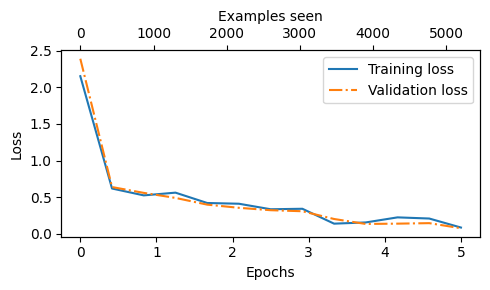

In [149]:

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

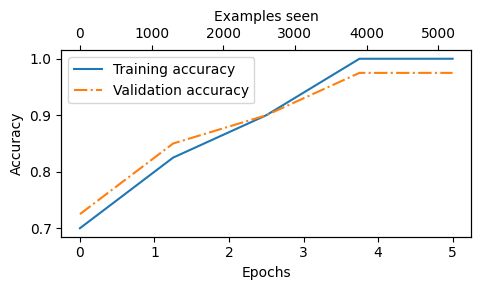

In [147]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [148]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 96.64%
Test accuracy: 95.36%


* We can see that the training and validation set performances are practically identical
* However, based on the slightly lower test set performance, we can see that the model overfits the training data to a very small degree, as well as the validation data that has been used for tweaking some of the hyperparameters, such as the learning rate
* This is normal, however, and this gap could potentially be further reduced by increasing the model's dropout rate (drop_rate) or the weight_decay in the optimizer setting

lets use the FineTuned model now

In [150]:
def classify_review(text, model, tokenizer, device, max_length= None, pad_token_id= 50256):
    model.eval()

    # prepare inputs to the model
    input_ids= tokenizer.encode(text)
    supported_context_length= model.pos_emb.weight.shape[0]

    # truncate the sequences if they are too long
    max_len= min(max_length, supported_context_length) if max_length is not None else supported_context_length
    input_ids= input_ids[:max_len]

    # pad the sequence to the longest sequence
    input_ids += [pad_token_id] * (max_len - len(input_ids))
    input_tensor = torch.tensor(input_ids, device= device).unsqueeze(0)

    # model inference
    with torch.no_grad():
        logits= model(input_tensor) [:, -1, :]        # get the last token output scores
    predicted_label= torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label==1 else "not spam"



In [151]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [153]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [154]:
torch.save(model.state_dict(), "review_classifier.pth")

if we load the model in a new session

In [ ]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>